Found 24 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.5417 - loss: 0.7363 - val_accuracy: 0.5000 - val_loss: 0.8700 - learning_rate: 1.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 0.7463 - val_accuracy: 0.5000 - val_loss: 1.1919 - learning_rate: 1.0000e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6250 - loss: 0.5680 - val_accuracy: 0.5000 - val_loss: 0.9322 - learning_rate: 1.0000e-04
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6250 - loss: 0.6117 - val_accuracy: 0.5000 - val_loss: 0.8965 - learning_rate: 1.0000e-04
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6667 - loss: 0.4910 - val_accuracy: 0.5000 - val_loss: 0.8323 - learning_rate: 1.0000e-05
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7917 - loss: 0.4776 - val_accuracy: 0.5000 - val_loss: 0.8549 - learning_rate: 1.0000e-05
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8333 - loss: 0.4333 - val_accuracy: 0.50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


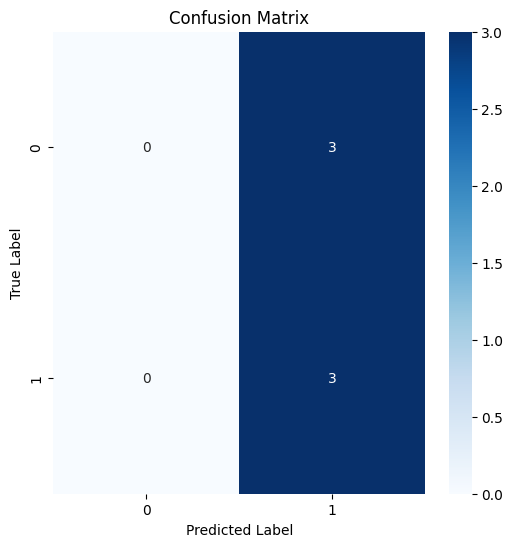

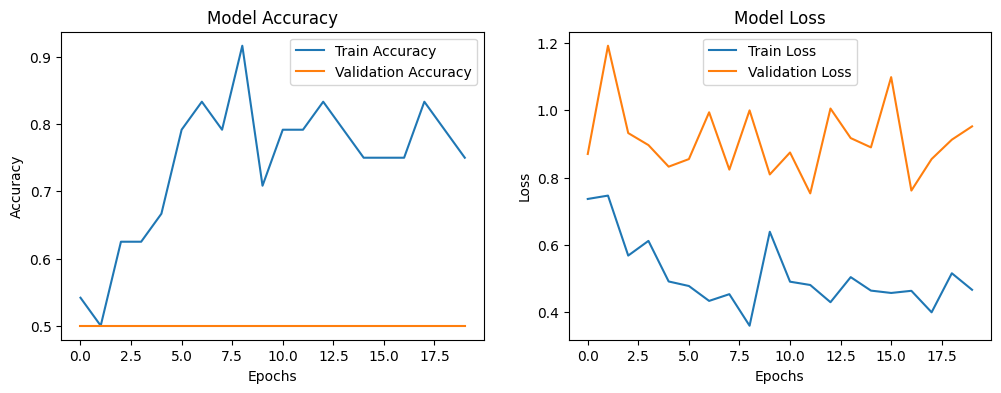

In [ ]:
#MOBILENETV2 MODEL WITH XAI IMPLEMENTATIONS
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, callbacks
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define paths
data_dir = "/kaggle/input/glaucomadataset-healthy-and-infected-images/datasets combined"

# Image Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load Training and Validation Data
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load MobileNetV2 Pre-trained Model
base_model = MobileNetV2(weights="/kaggle/input/mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5",
                         include_top=False, input_shape=(224, 224, 3))

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Healthy vs Glaucoma)
])

# Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Early Stopping & Reduce LR on Plateau)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[reduce_lr]
)


# ------------------ MODEL EVALUATION ------------------
# Save Model
model.save("mobilenetv2_glaucoma_model.keras")
print("Training completed and model saved!")

# Compute the confusion matrix
predictions = model.predict(val_data)

# Convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype("int32")

# True labels
true_labels = val_data.classes

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:\n", cm)
report = classification_report(true_labels, predicted_classes, target_names=['Healthy', 'Glaucoma'])
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix.png", bbox_inches='tight')
plt.show()

# ------------------ TRAINING HISTORY PLOTS ------------------
plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()



Training KNN...
Model saved to glaucoma_model_KNN.joblib

Model Performance:
accuracy: 0.5120
precision: 0.5131
recall: 0.5090
f1: 0.5110
auc: 0.5108

Confusion Matrix:


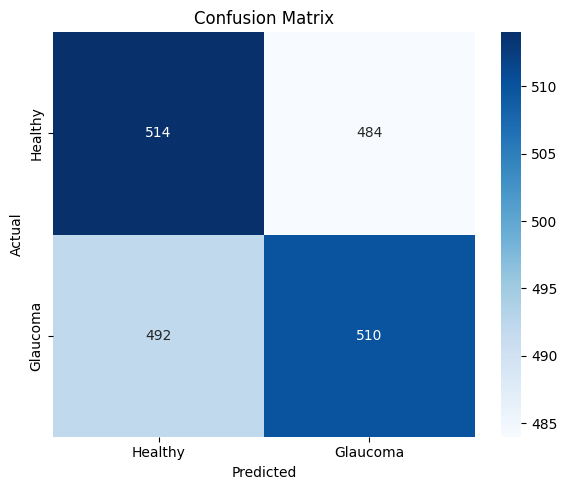

KNN Predictions: [0.4 0.8 0.8 ... 0.2 0.4 0.4]


In [8]:
### knn model:

from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_best_params():
    try:
        with open('fast_hyperopt_results.json', 'r') as f:
            return json.load(f)['best_parameters'].get('KNN', {})
    except FileNotFoundError:
        try:
            with open('hyperparameter_optimization_results.json', 'r') as f:
                return json.load(f)['best_parameters'].get('KNN', {})
        except FileNotFoundError:
            return {}

def train(X_train, y_train):
    best_params = load_best_params()
    default_params = {'n_neighbors': 5}
    model_params = {**default_params, **best_params}
    
    pipeline = ImbPipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', KNeighborsClassifier(**model_params))
    ])
    
    print("\nTraining KNN...")
    pipeline.fit(X_train, y_train)
    
    model_path = 'glaucoma_model_KNN.joblib'
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")
    
    return pipeline

def evaluate(model, X, y):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X)[:, 1]
    else:
        y_prob = model.predict(X)
    
    y_pred = (y_prob >= 0.5).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'auc': roc_auc_score(y, y_prob)
    }
    
    return metrics, y_pred

def predict(model, X):
    return model.predict(X)

def predict_proba(model, X):
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)
    return model.predict(X)

def load_model(filepath='glaucoma_model_KNN.joblib'):
    return joblib.load(filepath)

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix_knn.png")  # Save image
    plt.show()

def main():
    # Load and preprocess data
    data = pd.read_csv("/kaggle/input/project/glaucoma_dataset.csv")
    X = data.drop('Diagnosis', axis=1).select_dtypes(include=['number']).fillna(0)
    y = (data['Diagnosis'] == 'Glaucoma').astype(int)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_test)

    # Train model
    model = train(X_train_scaled, y_train)

    # Evaluate model
    metrics, y_val_pred = evaluate(model, X_val_scaled, y_test)
    print("\nModel Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_test, y_val_pred, labels=["Healthy", "Glaucoma"])

    return model, X_train_scaled, X_val_scaled, y_train, y_test

if __name__ == "__main__":
    knn_model, X_train_scaled, X_val_scaled, y_train, y_test = main()

    # Optional: Get prediction probabilities for further use
    knn_predictions = knn_model.predict_proba(X_train_scaled)[:, 1]
    print("KNN Predictions:", knn_predictions)


In [5]:
import joblib
import tensorflow as tf

# Load MobileNetV2 Model (Image Model)
mobilenet_model = tf.keras.models.load_model("/kaggle/input/mobilenetv2-model/keras/default/1/mobilenetv2_glaucoma_model.keras")  

# Load KNN Model (Statistical Model)
knn_model = joblib.load("/kaggle/working/glaucoma_model_KNN.joblib")  


In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define paths
image_dir = "/kaggle/input/glaucomadataset-healthy-and-infected-images/datasets combined"  
img_size = (224, 224)  # MobileNetV2 default input size

def load_and_preprocess_images(image_dir):
    image_list = []
    labels = []
    filenames = []  # To track file names
    
    for category in ["healthy", "glaucoma_project"]:  # Adjust folder names if needed
        category_path = os.path.join(image_dir, category)
        
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            
            # Load image and resize
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            
            # Preprocess image for MobileNetV2
            img_array = preprocess_input(img_array)  
            
            image_list.append(img_array)
            filenames.append(filename)
            
            # Assign label (0 = healthy, 1 = glaucoma)
            labels.append(0 if category == "healthy" else 1)

    return np.array(image_list), np.array(labels), filenames

# Load dataset
X, y, image_filenames = load_and_preprocess_images(image_dir)
print(f"Total images loaded: {len(X)}")  # Should be 30

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, train_filenames, test_filenames = train_test_split(
    X, y, image_filenames, test_size=0.2, stratify=y, random_state=42
)

print(f"Training images: {len(X_train)}, Testing images: {len(X_test)}")
print(f"y_test shape: {y_test.shape}")
predictions = model.predict(X_test)

# Convert probabilities to binary (0 = Healthy, 1 = Glaucoma)
predicted_labels = (predictions > 0.5).astype(int)

# Show some predictions with filenames
for i in range(5):  # Display first 5 predictions
    print(f"Image: {test_filenames[i]}, Predicted: {'Glaucoma' if predicted_labels[i] == 1 else 'Healthy'}")



Total images loaded: 30
Training images: 24, Testing images: 6
y_test shape: (6,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: infected_e.jpg, Predicted: Glaucoma
Image: 13_h.jpg, Predicted: Glaucoma
Image: infected_i.jpg, Predicted: Healthy
Image: 05_h.jpg, Predicted: Glaucoma
Image: infected_k.jpg, Predicted: Glaucoma


In [7]:
from tensorflow.keras.models import load_model

# Load the trained MobileNetV2 model
mobilenet_model = load_model("/kaggle/input/mobilenetv2-model/keras/default/1/mobilenetv2_glaucoma_model.keras")  # Update the path
print("Model loaded successfully!")

Model loaded successfully!


In [8]:
# Make predictions on test data
predictions = model.predict(X_test)

# Convert probabilities to binary (0 = Healthy, 1 = Glaucoma)
predicted_labels = (predictions > 0.5).astype(int)

# Show some predictions with filenames
for i in range(5):  # Display first 5 predictions
    print(f"Image: {test_filenames[i]}, Predicted: {'Glaucoma' if predicted_labels[i] == 1 else 'Healthy'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Image: infected_e.jpg, Predicted: Glaucoma
Image: 13_h.jpg, Predicted: Glaucoma
Image: infected_i.jpg, Predicted: Healthy
Image: 05_h.jpg, Predicted: Glaucoma
Image: infected_k.jpg, Predicted: Glaucoma


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Compute accuracy
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=["Healthy", "Glaucoma"]))

# Compute the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))


Test Accuracy: 33.33%
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
    Glaucoma       0.40      0.67      0.50         3

    accuracy                           0.33         6
   macro avg       0.20      0.33      0.25         6
weighted avg       0.20      0.33      0.25         6

Confusion Matrix:
[[0 3]
 [1 2]]


In [ ]:
import numpy as np
# Sample MobileNetV2 predictions as labels (Glaucoma or Healthy)
predictions = ["Glaucoma", "Glaucoma", "Healthy", "Glaucoma", "Healthy"]
# Convert MobileNetV2 predictions to binary (0 = Healthy, 1 = Glaucoma)
mobilenet_binary = np.array([1 if pred == "Glaucoma" else 0 for pred in predictions])

# Sample KNN predictions (probabilities)
knn_predictions = np.array([0.4, 0.8, 0.8, 0.2, 0.4])  # Example probabilities

# Convert KNN probabilities to binary (0 = Healthy, 1 = Glaucoma), threshold = 0.5
knn_binary = (knn_predictions >= 0.5).astype(int)

# Now both mobilenet_binary and knn_binary have the same length
print(f"MobileNetV2 predictions (binary): {mobilenet_binary}")
print(f"KNN predictions (binary): {knn_binary}")

#

# Convert combined predictions into binary values (0 or 1) based on the threshold (0.5)
final_predictions = (combined_predictions >= 0.5).astype(int)

print(f"Final combined predictions: {final_predictions}")

print(f"final_predictions shape: {final_predictions.shape}")


MobileNetV2 predictions (binary): [1 1 0 1 0]
KNN predictions (binary): [0 1 1 0 0]
Final combined predictions: [1 1 1 1 0]
final_predictions shape: (5,)


Total images loaded: 30
Epoch 1/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4211 - loss: 0.8347 - val_accuracy: 0.4000 - val_loss: 0.8329
Epoch 2/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.4000 - val_loss: 1.2543
Epoch 3/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.4000 - val_loss: 1.6694
Epoch 4/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.4000 - val_loss: 1.8975
Epoch 5/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 8.7748e-04 - val_accuracy: 0.4000 - val_loss: 1.9564
Epoch 6/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 4.2181e-04 - val_accuracy: 0.4000 - val_loss: 1.9504
Epoch 7/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 2.3016e-04 - val_accuracy: 0.4000 - val_loss: 1.8827
Epoch 8/22
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 1.3439e-04 - val_accuracy: 

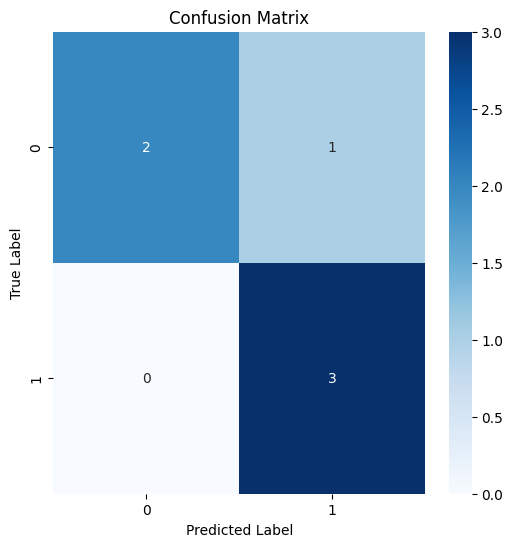

In [18]:
#MODAL FUSION OF KNN AND MOBILENETV2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier

# Set image directory and size
image_dir = "/kaggle/input/glaucomadataset-healthy-and-infected-images/datasets combined"
img_size = (224, 224)

# Load and preprocess images
def load_and_preprocess_images(image_dir):
    image_list, labels, filenames = [], [], []
    for category in ["healthy", "glaucoma_project"]:
        category_path = os.path.join(image_dir, category)
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)
            image_list.append(img_array)
            filenames.append(filename)
            labels.append(0 if category == "healthy" else 1)
    return np.array(image_list), np.array(labels), filenames

# Load dataset
X, y, image_filenames = load_and_preprocess_images(image_dir)
print(f"Total images loaded: {len(X)}")

# Split dataset
X_train, X_test, y_train, y_test, train_filenames, test_filenames = train_test_split(
    X, y, image_filenames, test_size=0.2, stratify=y, random_state=42
)

# Data augmentation (if needed for training the CNN)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

# Build MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train MobileNetV2 model
cnn_model.fit(X_train, y_train, epochs=22, validation_split=0.2)

# Feature extractor (for KNN)
features_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])
train_features = features_model.predict(X_train)
test_features = features_model.predict(X_test)

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, y_train)
knn_probs = knn.predict_proba(test_features)[:, 1]

# Predict using CNN
mobilenet_probs = cnn_model.predict(X_test).flatten()

# Combine MobileNetV2 and KNN predictions
combined_probs = (mobilenet_probs + knn_probs) / 2
final_predictions = (combined_probs >= 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
cm = confusion_matrix(y_test, final_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


